# Demo Frozen Lake DQN Agent
 - Demos the Deep Q Network (DQN) off-policy RL agent for the Frozen Lake problem

#### Installs

In [1]:
# ! pip install gymnasium torch numpy matplotlib pyvirtualdisplay


#### Imports

In [2]:
import random
import numpy as np                                       # numerical ops
import gymnasium as gym                                  # Gymnasium environments
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from pyvirtualdisplay import Display                     # headless display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from typing import List, Any
import os, sys

sys.path.insert(1, "../")
import src.main.configs.global_configs as configs
from src.main.utility.chart_results import ChartResults


#### Define global configs and variables

In [3]:
# Rendering configs
DPI = 72
INTERVAL = 100 # ms

#### Utility class of helper functions

In [4]:
class Helpers:
  """
  Utility class of helper functions
  """
  @staticmethod
  def animateEnvironment(images: List[Any]):
    """
    Animates the environment
    :param images: Images
    """
    plt.figure(
        figsize=(images[0].shape[1]/DPI,images[0].shape[0]/DPI),
        dpi=DPI
        )
    patch = plt.imshow(images[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(images[i])
    ani = FuncAnimation(
        plt.gcf(),
        animate,
        frames=len(images),
        interval=INTERVAL)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()

  @staticmethod
  def toOneHotEncoding(state: int, state_size: int) -> np.ndarray:
    """
    Converts a state to a one-hot vector
    :param state: State
    :param state_size: State size
    :return: One-hot vector
    """
    vec = np.zeros(state_size, dtype=np.float32)
    vec[state] = 1.0
    return vec

#### Solution steps:
 - Step 1: Implement Replay buffer
 - Step 2: Implement the RL training loop
 - Step 3: Implement the RL evaluation (animation) policy

##### Step 1: Implement Deep Q Network

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.net(x)


##### Step 2: Implement Replay buffer

In [6]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = zip(*batch)
        return (np.vstack(s), np.array(a), np.array(r, dtype=np.float32),
                np.vstack(s2), np.array(d, dtype=np.uint8))

    def __len__(self):
        return len(self.buffer)


##### Step 3: RL training loop

In [7]:
class DqnAgentTrainingLoop:
  """
  DQN agent training loop
  """
  def __init__(
      self,
      env,
      n_episodes=1200,
      batch_size=64,
      gamma=0.99,
      lr=1e-3,
      target_update=50,
      epsilon = 1.0,
      eps_decay = 0.995,
      eps_min = 0.01
  ):
    """
    Initializes the DQN agent training loop
    :param env: Environment
    :param n_episodes: Number of episodes
    :param batch_size: Batch size
    :param gamma: Discount factor
    :param lr: Learning rate
    :param target_update: Target update frequency
    :param epsilon: Epsilon
    :param eps_decay: Epsilon decay
    :param eps_min: Epsilon minimum
    """
    self.env = env
    self.n_episodes = n_episodes
    self.batch_size = batch_size
    self.gamma = gamma
    self.lr = lr
    self.target_update = target_update
    self.epsilon = epsilon
    self.eps_decay = eps_decay
    self.eps_min = eps_min

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.state_size = env.observation_space.n
    self.action_size = env.action_space.n

    self.q_network = QNetwork(self.state_size, self.action_size).to(self.device)
    self.target_network = QNetwork(self.state_size, self.action_size).to(self.device)
    self.target_network.load_state_dict(self.q_network.state_dict())
    self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
    self.replay_buffer = ReplayBuffer()

  def _selectAction(
    self,
    q_net: QNetwork,
    state: Any,
    epsilon: float,
    n_actions: int) -> int:
    """
    Selects an action
    :param q_net: Q network
    :param state: State
    :param epsilon: Epsilon
    :param n_actions: Number of actions
    :return: Action
    """
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        return q_net(torch.FloatTensor(state)).argmax().item()

  def train(self):
    """
    Trains the DQN agent
    """
    all_rewards = []

    for ep in range(1, self.n_episodes+1):
        state, _ = self.env.reset()
        state = Helpers.toOneHotEncoding(state, self.state_size)
        total_r = 0

        done = False
        while not done:
            action = self._selectAction(
                self.q_network,
                state,
                self.epsilon,
                self.action_size)
            next_state, reward, done, _, _ = self.env.step(action)
            next_state = Helpers.toOneHotEncoding(next_state, self.state_size)

            self.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_r += reward

            if len(self.replay_buffer) >= self.batch_size:
                s, a, r, s2, d = self.replay_buffer.sample(self.batch_size)
                s  = torch.FloatTensor(s)
                a  = torch.LongTensor(a)
                r  = torch.FloatTensor(r)
                s2 = torch.FloatTensor(s2)
                d  = torch.BoolTensor(d)

                # Current Q
                q_vals = self.q_network(s).gather(1, a.unsqueeze(1)).squeeze(1)
                # Next Q from target network
                next_q = self.target_network(s2).max(1)[0]
                next_q[d] = 0.0  # zero for terminal states
                # DQN loss
                target = r + self.gamma * next_q
                loss = nn.functional.mse_loss(q_vals, target.detach())

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.eps_min, self.epsilon * self.eps_decay)
        all_rewards.append(total_r)

        # Periodic target network update
        if ep % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        if ep % 200 == 0:
            print(f"Episode {ep}, AvgReward {np.mean(all_rewards[-200:]):.3f}")

    return self.q_network, all_rewards

  @property
  def q_net(self) -> QNetwork:
    """
    Getter for the Q network
    :return: Q network
    """
    return self.q_network

Episode 200, AvgReward 0.040
Episode 400, AvgReward 0.160
Episode 600, AvgReward 0.820
Episode 800, AvgReward 0.970
Episode 1000, AvgReward 0.680
Episode 1200, AvgReward 0.960





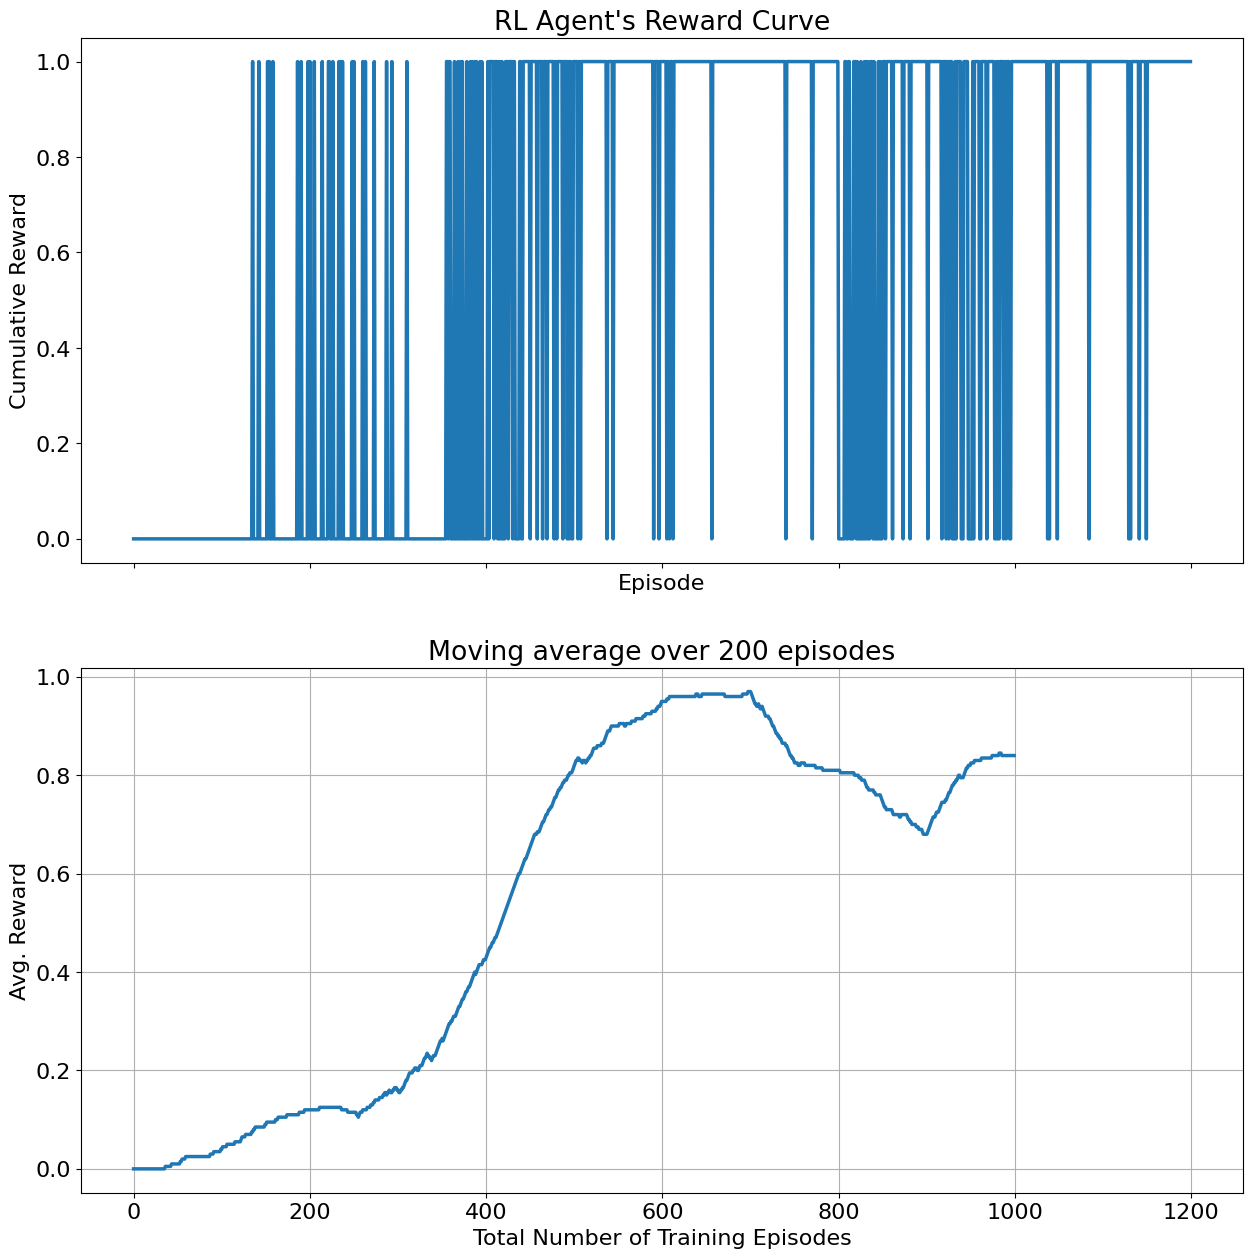

In [8]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
agent = DqnAgentTrainingLoop(env)
q_net, rewards = agent.train()
print("\n\n")
ChartResults.plotRewardCurve(rewards, window_size=200)

##### Step 4: Implement the RL evaluation (animation) policy

In [9]:
class EvaluateDQNAgent:
  """
  Evaluate the DQN RL agent using animation of the simulation runs
  """
  def __init__(
      self, 
      agent, 
      env, 
      n_episodes=10,
      render_mode=configs.RENDER_MODE
  ):
    """
    Constructor
    :param agent: RL Agent
    :param env: Environment
    :param n_episodes: Number of episodes to run    
    :param render_mode: Render mode
    """
    self.agent = agent
    self.env = env
    self.render_mode = render_mode
    self.n_episodes = n_episodes
      
    if self.render_mode == "human":
        self.display = None
    else:
        self.display = Display(visible=0, size=(400, 400))
        self.display.start()
    
    self.trajectories = []
    self.images = []

  def _evaluate(self):
    """
    Evaluate the agent
    """
    for ep in range(self.n_episodes):
      state, _ = self.env.reset()
      self.trajectories.append(state)
      one_hot = lambda s: np.eye(self.env.observation_space.n, dtype=np.float32)[s]
      done = False

      #while not done:
      for _ in range(100):
        a = self.agent.q_net(torch.FloatTensor(one_hot(state))).argmax().item()
        state, _, done, _, _ = self.env.step(a)
        self.trajectories.append(state)
        
        if self.render_mode == "human":
            self.env.render()
        else:
            self.images.append(self.env.render())

        if done:
              break

      # self.env.close()

  def run(self):
    """
    Run the RL evaluation with animation
    """
    self._evaluate()
    if self.render_mode != "human":
        Helpers.animateEnvironment(self.images)

In [10]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="human")
# env.metadata["render_fps"] = 8
evaluate = EvaluateDQNAgent(agent, env, render_mode="human")
evaluate.run()